## 11. Adaptive radial map stochastic map filter for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# Plots.font("sans-serif")
# clibrary(:colorbrewer)
# gr()
pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["text.usetex"] = true;
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [4]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.05
Δtobs = 0.4

0.4

Define the time span of interest

In [6]:
t0 = 0.0
tf = 4000.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

10000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [8]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [9]:
### Process and observation noise
σx = 1e-6
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

In [10]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [11]:
# Time span
tspan = (0.0, tf)

(0.0, 4000.0)

Set initial condition of the true system

In [12]:
x0 = rand(model.π0);

In [13]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [14]:
# Ensemble size
Ne = 160

X0 = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X0, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×160 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
 -0.819835  0.285373  0.561409  -0.427789  …  -0.530588  0.665081  0.357529
  1.55152   1.06559   0.54881   -1.04211      -0.858848  0.720951  0.627054
  0.506649  1.78508   0.2921     0.318384      1.62759   1.74226   1.10678

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [15]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)

Stochastic EnKF  with filtered = false


In [16]:
Xenkf = seqassim(F, data, Tf, model.ϵx, enkf, deepcopy(X0), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


In [17]:
tspin = 1000.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)
tburn = 1000.0
Tburn = ceil(Int64, (tburn-t0)/Δtobs)

2500

Time average root-mean-squared error 

In [18]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), Tspin+Tburn:Tf))

1.1055661318596457

Initialize the ensemble matrix for the radial stochastic map filter

In [19]:
Xspin = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))
observe(h, Xspin, tspin, Ny, Nx)
ϵy(Xspin, 1, Ny)
Xspin

6×160 Array{Float64,2}:
 -3.32784  -0.969952  -4.49186  -0.529333  …  -0.381753   1.05612   -2.41507
 -2.68897  -1.12483   -2.50997  -3.35306      -1.10186   -2.73162   -1.40597
 22.8712   22.8788    22.9126   22.2675       23.3522    25.6105    25.2236
 -2.72533  -3.25042   -3.98274  -2.26029      -3.06908   -2.30093   -2.24468
 -2.11935  -1.53097   -3.39979  -1.19236      -1.33161   -0.985207  -0.546887
 21.6982   24.0683    22.8929   22.1587    …  23.9621    22.6916    23.3231

Free run of the Lorenz-63 to collect samples of the stationary distribution and the associated observations

In [20]:
using StatsBase

In [21]:
xfreerun = rand(model.π0)
tfreerun = 10000
Tfreerun = ceil(Int64, (tfreerun-t0)/Δtobs)
Tdiscard = 1000
Δdiscard = 10

10

In [22]:
data_freerun = generate_lorenz63(model, xfreerun, Tfreerun)

SyntheticData([0.4, 0.8, 1.2000000000000002, 1.6, 2.0, 2.4000000000000004, 2.8000000000000003, 3.2, 3.6, 4.0  …  9996.400000000001, 9996.800000000001, 9997.2, 9997.6, 9998.0, 9998.400000000001, 9998.800000000001, 9999.2, 9999.6, 10000.0], [0.542715774325243, 0.5392017361480038, 0.4500502146774873], [19.71525965596253 -7.9358485917303785 … -1.0247004797289077 -0.3431929493907648; 18.644479404823922 -9.353167557394913 … 0.5316981153447753 -0.6574115436626289; 44.37104406168299 25.330915438960815 … 22.146927702108766 7.6262385982665615], [17.67867320443561 -9.995025838872461 … -1.9905608873095708 -3.8576161092946357; 21.612697176027595 -9.235055701711557 … -2.027416090367069 2.5320934594704956; 42.577159206075706 28.902922564513293 … 20.750955568618732 8.785462112496887])

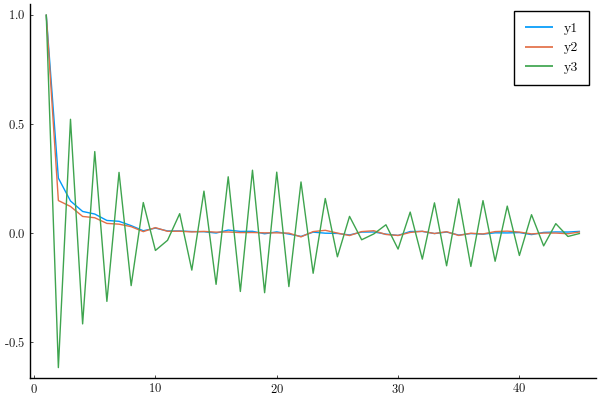

In [23]:
plot(autocor(data_freerun.xt[1,:]))
plot!(autocor(data_freerun.xt[2,:]))
plot!(autocor(data_freerun.xt[3,:]))

We want to learn as many maps of dimension Nx+1 as we have observations, i.e. Ny maps of dimensions Nx+1

In [24]:
poff = 2
pdiag = 0

γ = 2.0
λ = 0.0
δ = 1e-8
κ = 10.0
β = 1.0

dist = Float64.(metric_lorenz(3))
idx = vcat(collect(1:Ny)',collect(1:Ny)')

2×3 Array{Int64,2}:
 1  2  3
 1  2  3

In [25]:
Slist = SparseRadialMap[]

@time for i=1:Ny
    idx1, idx2 = idx[:,i]
    perm = sortperm(view(dist,:,idx2))
    Xi = vcat(data_freerun.yt[i:i,Tdiscard:Δdiscard:end], data_freerun.xt[perm, Tdiscard:Δdiscard:end])
    Si = SparseRadialMap(Xi, -1; λ = λ, δ = δ, γ = γ)
    @time optimize(Si, Xi, poff, [1;0;0], "kfolds"; apply_rescaling = true, start = 2)
    push!(Slist, Si)
end

  7.670977 seconds (21.71 M allocations: 1.074 GiB, 3.75% gc time)
  0.102399 seconds (1.11 M allocations: 124.162 MiB, 26.21% gc time)
  0.097720 seconds (1.07 M allocations: 121.136 MiB, 19.67% gc time)
  8.630176 seconds (25.74 M allocations: 1.404 GiB, 3.86% gc time)


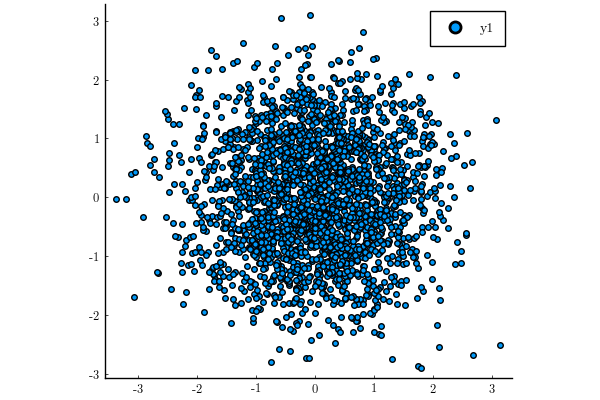

In [26]:
SpushX_freerun = Slist[1](vcat(data_freerun.yt[1:1,Tdiscard:Δdiscard:end], data_freerun.xt[:, Tdiscard:Δdiscard:end]))

scatter(SpushX_freerun[2,:], SpushX_freerun[3,:], ratio = 1.0)

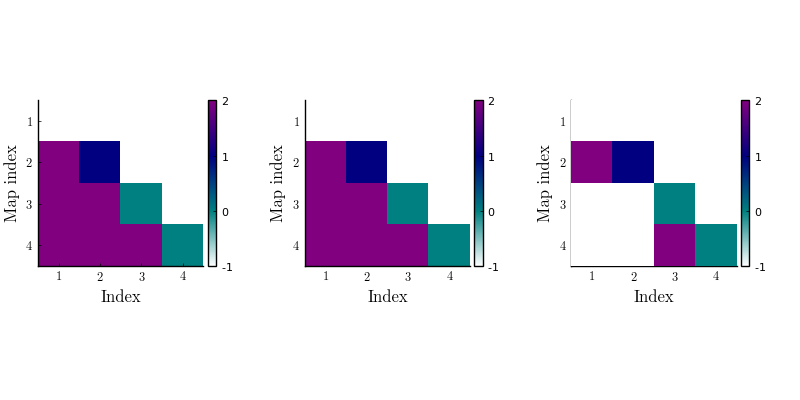

In [27]:
plt = plot(layout = grid(1, Nx), size = (800, 400))
for i=1:Ny
    plot!(plt[1,i], Slist[i])
end
plt

In [28]:
tsmf = 4000.0
Tsmf = ceil(Int64, (tsmf-tspin)/Δtobs)

7500

Initialize the structure of the map

In [29]:
p = 2
order = [[-1], [p; p], [-1; p; 0], [-1; p; p; 0]]

smf = SparseRadialSMF(x->x, F.h, β, ϵy, order, γ, λ, δ, κ, 
                      Ny, Nx, Ne, 
                      Δtdyn, Δtobs, 
                      dist, idx; islocalized = true)

SparseRadialSMF(var"#5#6"(), h, MultiplicativeInflation(1.0), AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]), Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 2], [-1, 2, 0], [-1, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
, 3, 3, 0.05, 0.4, [0.0 1.0 1.0; 1.0 0.0 1.0; 1.0 1.0 0.0], [1 2 3; 1 2 3], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], false, true)

In [30]:
poff = 2
pdiag = 0

γ = 2.0
λ = 0.0
δ = 1e-8
κ = 10.0
β = 1.0

dist = Float64.(metric_lorenz(3))
idx = vcat(collect(1:Ny)',collect(1:Ny)')

# Sgreedy = SparseRadialMap(Nx+1, -1; λ = λ, δ = δ, γ = γ)
Sgreedy = SparseRadialMap(vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:]), -1; λ = λ, δ = δ, γ = γ)
optimize(Sgreedy, vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:]), poff, [1;0;0], "kfolds";
         apply_rescaling = true, start = 2)

smf_greedy = AdaptiveSparseRadialSMF(x->x, F.h, β, ϵy, Slist,
                      Ny, Nx, 
                      Δtdyn, Δtobs, Inf, 
                      dist, idx, zeros(Nx+1, Ne), false, true)

AdaptiveSparseRadialSMF(var"#7#8"(), h, 1.0, AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]), SparseRadialMap[Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 1], [2, 2, 0], [2, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
, Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 1], [2, 2, 0], [2, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
, Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 1], [-1, -1, 0], [-1, -1, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
], 3, 3, 0.05, 0.4, Inf, [0.0 1.0 1.0; 1.0 0.0 1.0; 1.0 1.0 0.0], [1 2 3; 1 2 3], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], false, true)

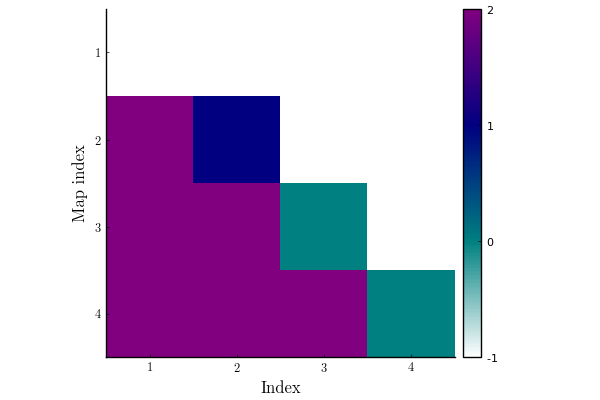

In [31]:
plot(Sgreedy)

In [39]:
Xsmf = seqassim(F, data, Tsmf, model.ϵx, smf, deepcopy(Xspin), model.Ny, model.Nx, tspin);

Progress:  17%|██████▉                                  |  ETA: 0:00:46

Max number of iterations is reached during the optimization

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


In [40]:
Xsmf_greedy = seqassim(F, data, Tsmf, model.ϵx, smf_greedy, deepcopy(Xspin), model.Ny, model.Nx, tspin);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


In [41]:
rmse_smf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf[i+1]; dims = 2))/sqrt(Nx), Tburn:Tsmf))

0.8514463727208215

In [42]:
(rmse_enkf-rmse_smf)/rmse_enkf

0.22985486965974222

In [43]:
rmse_greedysmf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf_greedy[i+1]; dims = 2))/sqrt(Nx), Tburn:Tsmf))

1.013115819976385

In [44]:
(rmse_enkf-rmse_greedysmf)/rmse_enkf

0.08362259770725093

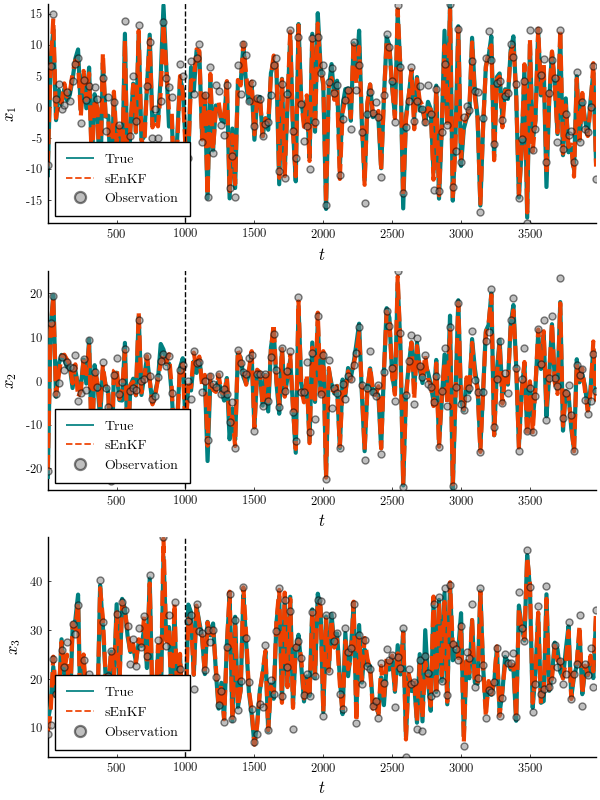

In [38]:
nb = 1
ne = Tspin+Tsmf
Δ = 50
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xenkf[1:Tspin+1], Xsmf_greedy[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
    vline!(plt[i,1], [tspin], color = :grey2, linestyle = :dash, label = "")
end

plt

### Verify that the greedy algorithm pick the right features, and generalizes well

In [318]:
# Define the distribution for initial condition
# Number of runs
Ne = 1000
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz63!,x0, tspan)

X = zeros(1+Nx, Ne) 

@inbounds for i=1:N
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[2:Nx+1,i] = deepcopy(sol.u[1])
end

In [319]:
observe((x,t)->x[1], X, 0.0, 1, Nx)
X[1:1,:] .+= σy*randn(1,Ne)

1×1000 view(::Array{Float64,2}, 1:1, :) with eltype Float64:
 2.83815  5.27057  3.56131  -5.28482  …  2.8327  7.46978  3.57976  -11.2344

In [320]:
Xtrain = copy(X[:,1:500])
Xtest = copy(X[:,501:end])

4×500 Array{Float64,2}:
 -3.43273   0.0417014  -4.59983   -4.66816  …   7.46978   3.57976   -11.2344
 -3.48789   0.794      -4.28858   -4.6038       2.86223   0.613946  -12.5439
 -5.5257   -5.01414     0.562741  -5.01289      1.40506   0.427375   -4.40145
 17.1983   28.4543     28.8784    21.667       23.3598   17.3182     39.3994

In [321]:
S = SparseRadialMap(Xtrain, -1; λ = λ, δ = δ, γ = γ)

Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [-1, -1], [-1, -1, -1], [-1, -1, -1, -1]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)


In [322]:
L = LinearTransform(Xtrain)

LinearTransform(4, [-0.1915018858300215, -0.2455118357666556, -0.4847148877769526, 23.465072988702126], [7.871922112562775 0.0 0.0 0.0; 0.0 7.6128783432651375 0.0 0.0; 0.0 0.0 8.459961651527458 0.0; 0.0 0.0 0.0 8.629288015871747], true)

In [323]:
C = SparseRadialMapComponent(Nx+1, -1)

Sparse radial map component of dimension 4 and order p = [-1, -1, -1, -1]


In [324]:
C, _ = greedyfit(Nx+1, 2, 0, transform(L, Xtrain), transform(L, Xtest), 4, λ, δ, γ; verbose = true)

Active dimensions: [4] - Training error: 0.49899898867465714, Validation error: 0.4991642188161073
Active dimensions: [1, 4] - Training error: 0.2892567186881934, Validation error: 0.3443127222678268
Active dimensions: [1, 3, 4] - Training error: 0.11042239860324271, Validation error: 0.15760843359887158
Active dimensions: [1, 2, 3, 4] - Training error: -0.21464624889558498, Validation error: -0.21383263935410138


(Sparse radial map component of dimension 4 and order p = [2, 2, 2, 0]
, ([0.49899898867465714, 0.2892567186881934, 0.11042239860324271, -0.21464624889558498], [0.4991642188161073, 0.3443127222678268, 0.15760843359887158, -0.21383263935410138]))

In [325]:
negative_likelihood(C, transform(L, Xtest), λ, δ)

-0.21383263935410138

In [326]:
negative_likelihood(C, transform(L, Xtrain), λ, δ)

-0.21464624889558498

In [327]:
Sxtrain = S(Xtrain; apply_rescaling = true)

4×500 Array{Float64,2}:
  0.384868   0.693868   0.476733  …  -0.400204   0.881486  1.68407
  0.54995    0.386163   0.474522      0.0206948  1.12206   1.46879
  0.892852   0.594454  -0.286251     -0.0166212  0.345552  1.84193
 -1.4052    -1.08497    0.736003     -0.702548   1.11114   0.126985

In [328]:
Sxtest = S(Xtest; apply_rescaling = true)

4×500 Array{Float64,2}:
 -0.411746   0.0296247  -0.560006  …   0.973241    0.479078  -1.40282
 -0.425907   0.136546   -0.531082      0.408222    0.112895  -1.61548
 -0.595864  -0.535396    0.123813      0.223378    0.107813  -0.462973
 -0.726217   0.578169    0.627314     -0.0121987  -0.712322   1.84653

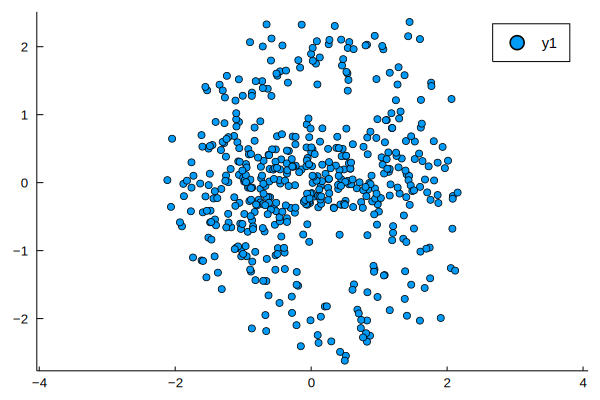

In [329]:
scatter(Sxtrain[4,:], Sxtrain[3,:], ratio = 1.0)

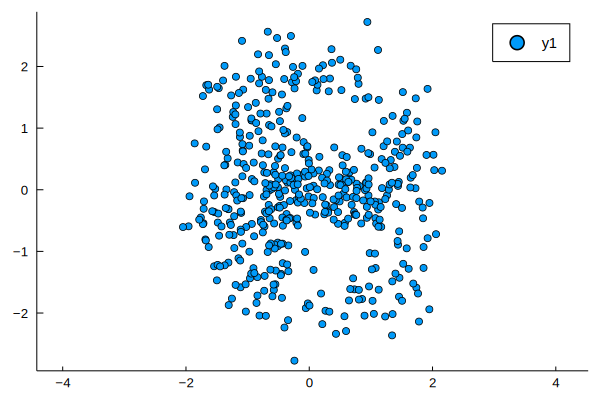

In [330]:
scatter(Sxtest[4,:], Sxtest[3,:], ratio = 1.0)

In [331]:
Xtest = vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:])
scatter(Xtest[1,:], Xtest[3,:], ratio = 1, legend =false)

@show norm(Xtest)
Sgreedy = SparseRadialMap(Xtest, -1; λ = λ, δ = δ, γ = γ)
@show norm(Xtest)

Sgreedy.L.L.diag - std(Xtest; dims = 2)[:,1]

@show norm(Xtest)
optimize(Sgreedy, Xtest, poff, [2;0;0], "kfolds";
         apply_rescaling = true, start = 2)
@show norm(Xtest)
Sx = deepcopy(Sgreedy(Xtest; apply_rescaling = true, start = 2))
@show norm(Xtest)

scatter(Xtest[2,:], Xtest[4,:], legend = false)

ystar = [2.5]

Xpost = deepcopy(Xtest)
inverse!(Xpost, Sx, Sgreedy, ystar; apply_rescaling = true)

norm(Sgreedy(vcat(ystar[1]*ones(1, Ne), Xpost[2:4,:]))[2:4,:]-Sx[2:4,:])

norm(Xtest) = 369.521382949262
norm(Xtest) = 369.521382949262
norm(Xtest) = 369.521382949262
norm(Xtest) = 369.521382949262
norm(Xtest) = 369.521382949262


LoadError: [91mArgumentError: number of columns of each array must match (got (1000, 160))[39m